# Problem (unicode1): Understanding Unicode (1 point)
(a) What Unicode character does chr(0) return?

Answer: it returns char \x00

In [8]:
chr(0)

'\x00'

(b) How does this character’s string representation (__repr__()) differ from its printed representation?

Answer: it printed representation is NULL, nothing is printed, __repr__() shows "'\\x00'"

In [15]:
print("\x00")
"\x00".__repr__()

 


"'\\x00'"

(c) What happens when this character occurs in text? It may be helpful to play around with the following in your Python interpreter and see if it matches your expectations:  

chr(0) 

print(chr(0)) 

"this is a test" + chr(0) + "string" 

print("this is a test" + chr(0) + "string")

Answer:

when chr(0) meets print it will show nothings, even a space.

when it shows up in a str, it will keep the form of \x00

In [16]:
chr(0) 

'\x00'

In [17]:
print(chr(0))

 


In [18]:
"this is a test" + chr(0) + "string"

'this is a test\x00string'

In [21]:
print("this is a test" + chr(0) + "string")

this is a test string


# Problem (unicode2): Unicode Encodings (3 points)

(a) What are some reasons to prefer training our tokenizer on UTF-8 encoded bytes, rather than UTF-16 or UTF-32? It may be helpful to compare the output of these encodings for various input strings.

Answer：maybe utf-16 and utf-32 represent the same str with more bytes than utf-8


In [23]:
Test = "Hello there, 你好世界！！"
utf8 = len(list(Test.encode("utf-8")))
utf16 = len(list(Test.encode("utf-16")))
utf32 = len(list(Test.encode("utf-32")))

print(utf8, utf16, utf32)

31 40 80


(b) Consider the following (incorrect) function, which is intended to decode a UTF-8 byte string into a Unicode string. Why is this function incorrect? Provide an example of an input byte string that yields incorrect results.

answer:decode_utf8_bytes_to_str_wrong("hello 你好".encode("utf-8")) wrong function pass *every single byte* and try to decode it, however in practice, we need serval byte input and get a mapping unicode standard output.

In [34]:
def decode_utf8_bytes_to_str_wrong(bytestring: bytes): return "".join([bytes([b]).decode("utf-8") for b in bytestring])

decode_utf8_bytes_to_str_wrong("你好".encode("utf-8"))

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 0: unexpected end of data

(c) Give a two byte sequence that does not decode to any Unicode character(s).

answer: double bytes sequence start with 110xxxxx, we choose a bytes beyond it and it supposed decoed with a longer bytes like 3 or 4, but we only provides a two bytes sequence and it return a failure 

In [36]:
bytes([255, 11]).decode("utf-8")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [51]:
list('hello'.encode("utf-8"))

[104, 101, 108, 108, 111]

# Problem (transformer_accounting): Transformer LM resource accounting (5 points)

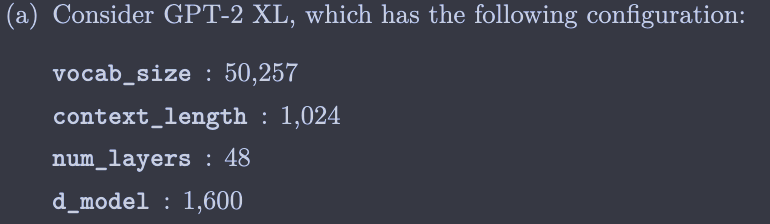
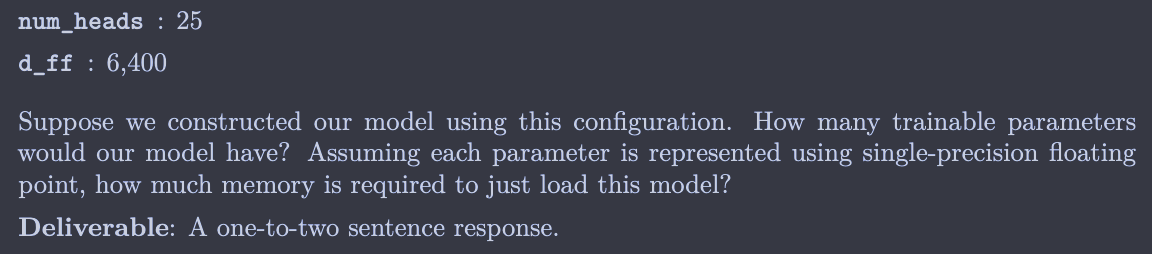

2,127,057,600个权重

8508230400/(1024∗1024∗1024)=8508230400/1073741824≈7.9238 GB

所以总共是 8508230400 bytes，约合 7.9238 GB。

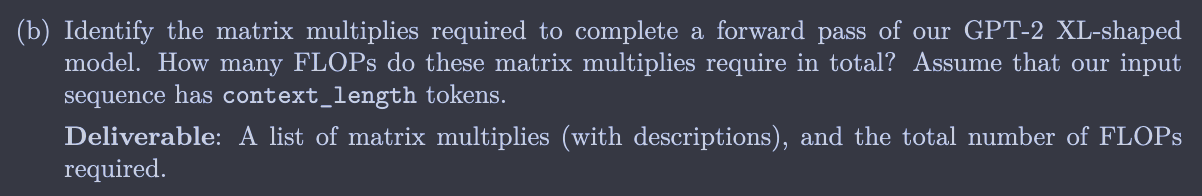

4.513 TFLOPs 

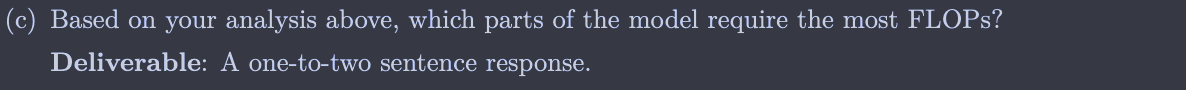

每个Transformer块中的前馈神经网络（FFNs）需要最多的浮点运算量，其次是自注意力机制。这些两个组件，特别是它们的矩阵乘法运算，支配了前向传递的计算成本。

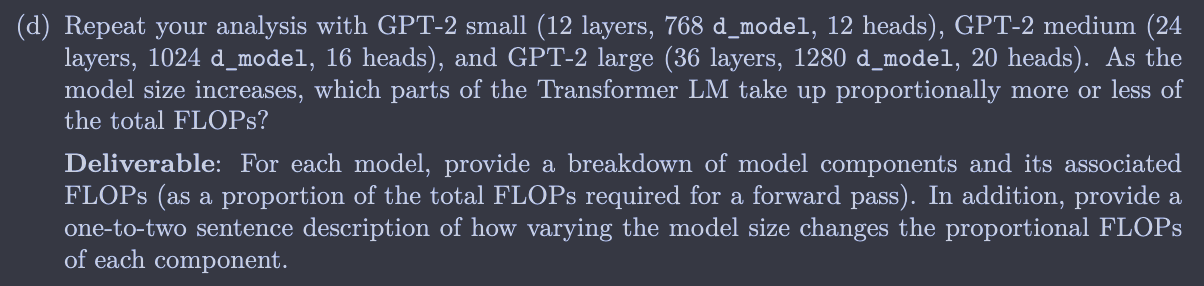

每个 Transformer Block 的 FLOPs:
QKV 投影: 6 * S * D^2
注意力分数: 2 * S^2 * D
加权值: 2 * S^2 * D
输出投影: 2 * S * D^2
FFN (W_gate): 2 * S * D * D_ff
FFN (W_up): 2 * S * D * D_ff
FFN (W_down): 2 * S * D_ff * D

注意力部分总计:
8*S*D^2 + 4*S^2*D
FFN (SwiGLU) 部分总计:
6*S*D*D_ff


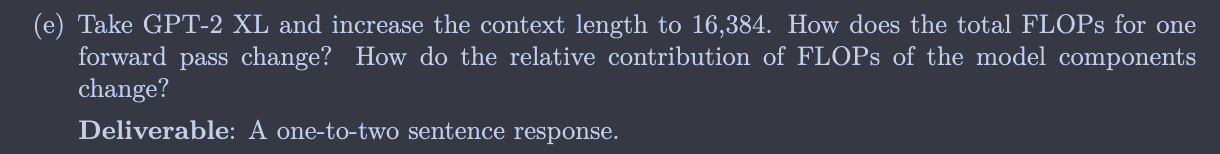

# Problem (learning_rate_tuning): Tuning the learning rate (1 point)

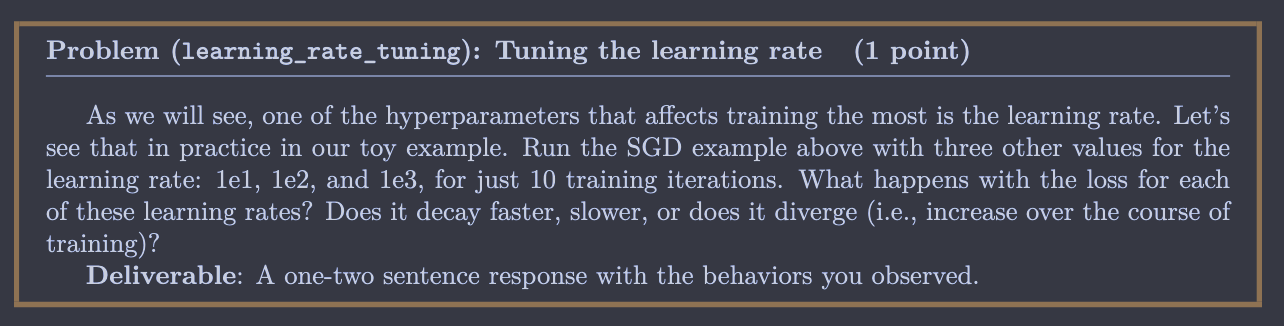

In [3]:
from collections.abc import Callable, Iterable
from typing import Optional
import torch
import math

class SGD(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3):
        if lr < 0:
            raise ValueError(f"Invalid learning rate: {lr}")
        defaults = {"lr": lr}
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable] = None):
        loss = None
        if closure is not None:
            # Note: The original image had 'if closure is None else closure()' which is unusual.
            # Assuming standard PyTorch behavior where closure is called if provided.
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"] # Get the learning rate.

            for p in group["params"]:
                if p.grad is None:
                    continue

                state = self.state[p] # Get state associated with p.
                t = state.get("t", 0) # Get iteration number from the state, or initial value.
                grad = p.grad.data # Get the gradient of loss with respect to p.

                p.data -= lr / math.sqrt(t + 1) * grad # Update weight tensor in-place.
                state["t"] = t + 1 # Increment iteration number.

        return loss

# Example usage based on your description:

for i in range(3):
    lr = [10, 100, 1000]
    torch.manual_seed(42)
    weights = torch.nn.Parameter(5 * torch.randn((10, 10)))
    opt = SGD([weights], lr=lr[i])
    print("LR=", lr[i])
    for t in range(10):
        opt.zero_grad() # Reset the gradients for all learnable parameters.
        loss = (weights**2).mean() # Compute a scalar loss value.
        print(loss.cpu().item())

        loss.backward() # Run backward pass, which computes gradients.
        opt.step() # Run optimizer step.

LR= 10
24.16925811767578
15.468326568603516
11.402588844299316
8.921309471130371
7.226260185241699
5.991397857666016
5.05294942855835
4.3178887367248535
3.72883677482605
3.2482311725616455
LR= 100
24.16925811767578
24.16925811767578
4.146788597106934
0.09924199432134628
1.336870115417992e-16
1.490024632424686e-18
5.017437842615996e-20
2.9889220257678576e-21
2.5640905147008167e-22
2.848989460778685e-23
LR= 1000
24.16925811767578
8725.1015625
1506962.5
167633488.0
13578311680.0
856946966528.0
43992855085056.0
1892760814616576.0
6.976313231409152e+16
2.240171378709889e+18


100损失下降最快，然后是10的损失下降，1000的根本没法收敛

# Problem (adamwAccounting): Resource accounting for training with AdamW (2 points)

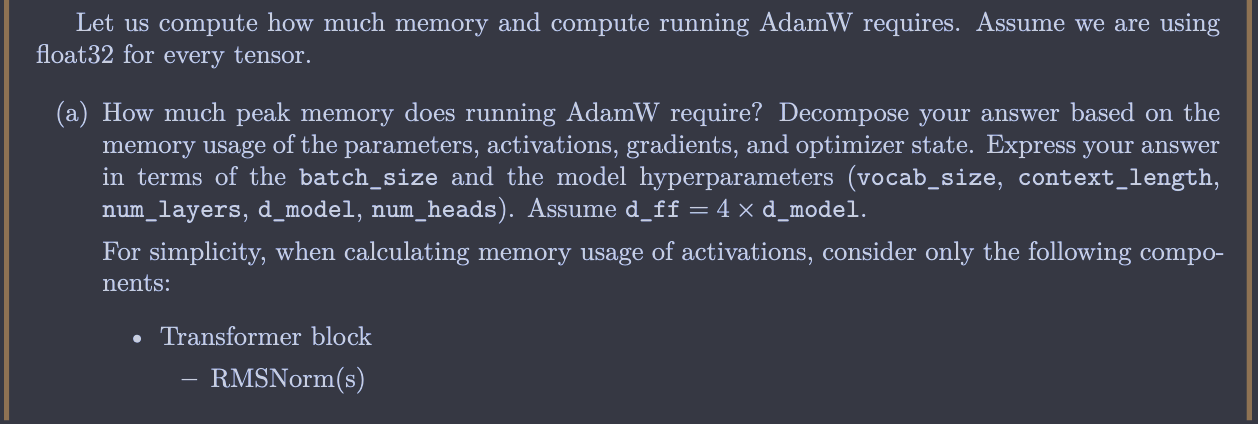
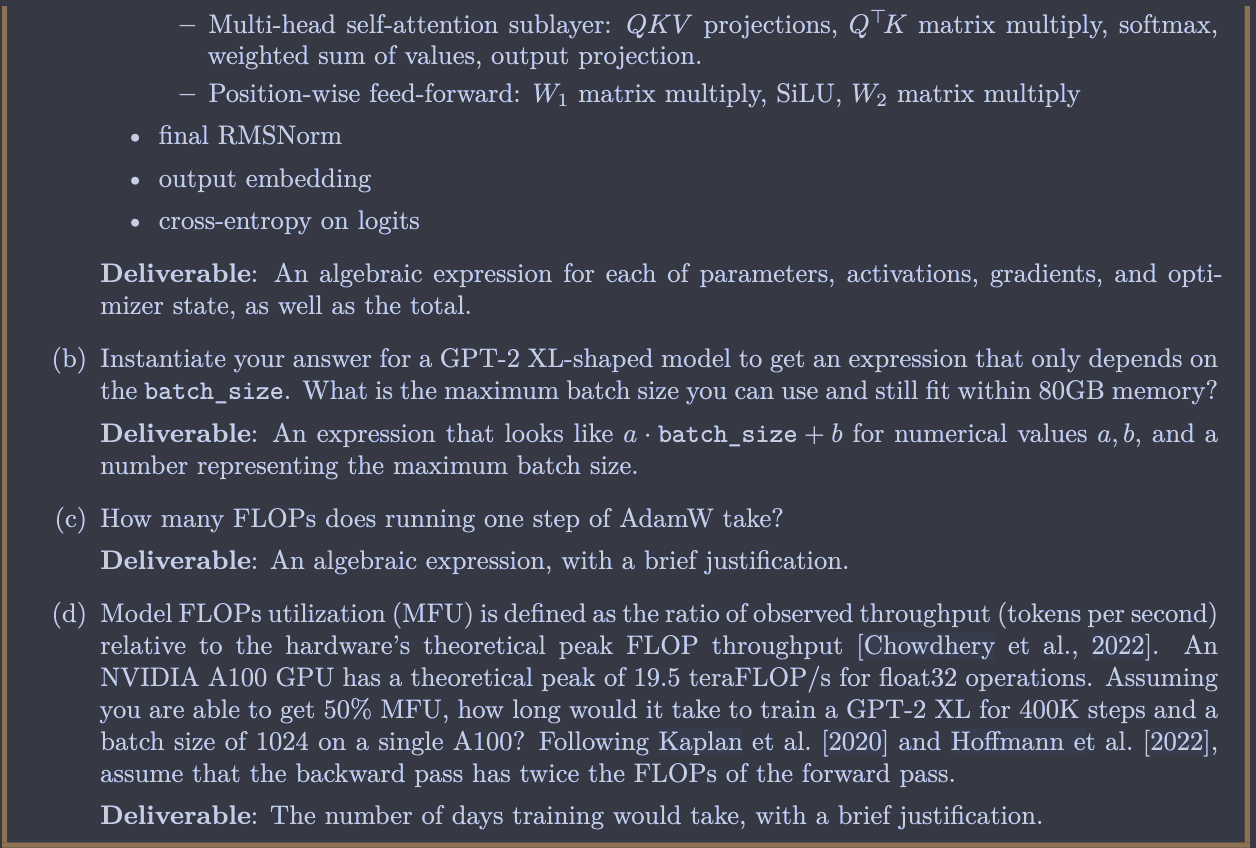